Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS152-OS152.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


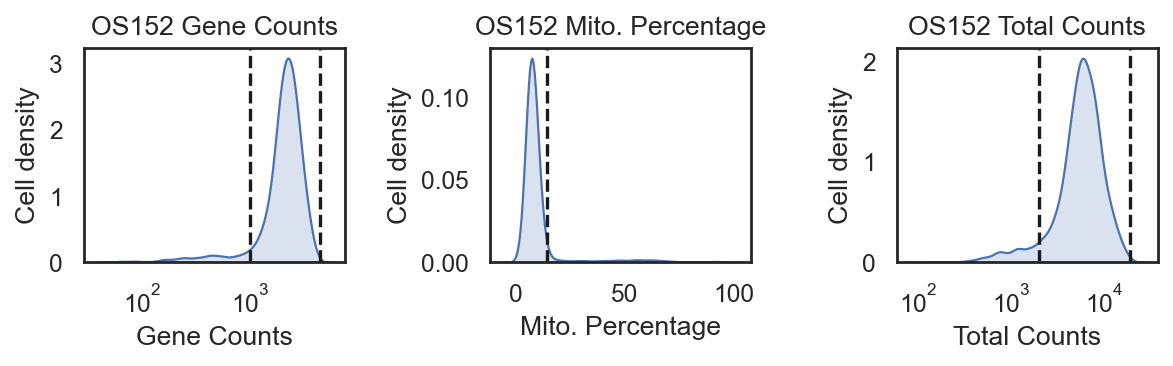

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:640: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)


Filtered out 53542 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
97
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    459 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    405 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:00:07)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


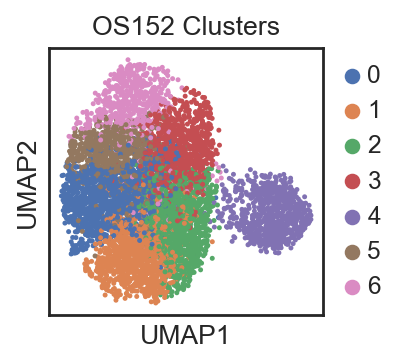

In [1]:
from svae import SpikeSlabVAE, metrics, sparse_shift, sVAE
from scipy.stats import chi2_contingency
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import anndata as AnnData
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib
import networkx
import anndata
import network
import fsspec
import igraph
import scvi
import h5py
import desc 
import umap
import svae
import os


%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
sc.set_figure_params(figsize=(2.2, 2.2))
np.random.seed(42)


# Reading in loom files
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS152/OS152.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-') 


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Data for the variables
variables = [
    ('n_genes_by_counts', [(4500, '--'), (1000, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(2000, '--'), (19000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS152 {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
#plt.savefig("/Users/brendamelano/Desktop/OS152_filtering_plain.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


# Filtering genes based on minimum counts 
scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)
#sc.pp.normalize_total(adata, target_sum=1e4)


# Filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# Log transformation
scv.pp.log1p(adata)


# Preserving the counts
adata.layers["counts"] = adata.X.copy() 


# Freezing the data in raw
# try moving to after selecting highly variable genes
adata.raw = adata


# Creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
# Research all the possible parameters for this
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)


# Making a variable for the genes names
genes = adata.var.index.values


# Make sure this shouldn't come after the scale
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))


# Split into s and g2m lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


# Saving object for cell cycle genes based on those in adata
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


# Scoring the cell cycle
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


# Computing the ccdifference score
adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


#adata.raw = adata
adata = adata[:, adata.var.highly_variable]


sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)


# Performing principal component analysis
sc.tl.pca(adata, svd_solver='arpack')


# Identifying neighbors for umap
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)


# Performing UMAP analysis
sc.tl.umap(adata)


# Leiden cluster
sc.tl.leiden(adata, resolution = 0.8)


# Plotting the umap
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS152 Clusters",
    size = 20
)

# DGEA for leiden cluster

In [ ]:
# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Creating a df for the cluster specific markers
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)


cluster_markers

# Subtype A module identification

In [ ]:
# Try to set this equal to the column that contains COL1A1 to automate it
cluster_id = '6'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS152_subtype_A_markers

In [15]:
# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv", OS152_subtype_A_markers, delimiter=",", fmt='%s')

OS152_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_A_markers.csv', header=None)

OS152_subtype_A_markers = OS152_subtype_A_markers.to_numpy()

OS742_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_A_markers.csv', header=None)

OS742_subtype_A_markers = OS742_subtype_A_markers.to_numpy()

OS384_subtype_A_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_A_markers.csv', header=None)

OS384_subtype_A_markers = OS384_subtype_A_markers.to_numpy()

# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_A_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_A_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_A_markers)))

# Find common genes that appear in two or more lists
common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv', index=False)

# Subtype B module identification

In [34]:
# Cluster IDs of interest
cluster_ids = [ '1','2']  # Adjust based on your clusters of interest

# Initialize empty lists to store data
genes_list = []
p_values_list = []
adjusted_p_values_list = []
log_fold_changes_list = []
scores_list = []

# Loop through each cluster to extract data
for cluster_id in cluster_ids:
    genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
    p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
    adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
    log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
    scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)
    
    # Append the extracted data for this cluster to the lists
    genes_list.append(genes)
    p_values_list.append(p_values)
    adjusted_p_values_list.append(adjusted_p_values)
    log_fold_changes_list.append(log_fold_changes)
    scores_list.append(scores)

# Concatenate data from all clusters of interest
cluster_markers = pd.concat([
    pd.DataFrame({
        'cluster_id': cluster_id,
        'genes': genes.values.flatten(),
        'p_values': p_values.values.flatten(),
        'adjusted_p_values': adjusted_p_values.values.flatten(),
        'log_fold_changes': log_fold_changes.values.flatten(),
        'scores': scores.values.flatten()
    }) for cluster_id, genes, p_values, adjusted_p_values, log_fold_changes, scores in zip(cluster_ids, genes_list, p_values_list, adjusted_p_values_list, log_fold_changes_list, scores_list)
], ignore_index=True)


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS152_subtype_B_markers

OS152_subtype_B_markers = OS152_subtype_B_markers.iloc[:, 1].tolist()

OS152_subtype_B_markers

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_B_markers.csv", OS152_subtype_B_markers, delimiter=",", fmt='%s')

OS152_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_B_markers.csv', header=None)

OS152_subtype_B_markers = OS152_subtype_B_markers.to_numpy()

OS384_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_B_markers.csv', header=None)

OS384_subtype_B_markers = OS384_subtype_B_markers.to_numpy()


OS742_subtype_B_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_B_markers.csv', header=None)

OS742_subtype_B_markers = OS742_subtype_B_markers.to_numpy()

# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_B_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_B_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_B_markers)))

# Find common genes that appear in two or more lists
common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv', index=False)


# Subtype C module identification

In [4]:
# Cluster IDs of interest
cluster_ids = [ '4']  # Adjust based on your clusters of interest


# Initialize empty lists to store data
genes_list = []
p_values_list = []
adjusted_p_values_list = []
log_fold_changes_list = []
scores_list = []

# Loop through each cluster to extract data
for cluster_id in cluster_ids:
    genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
    p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
    adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
    log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
    scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)
    
    # Append the extracted data for this cluster to the lists
    genes_list.append(genes)
    p_values_list.append(p_values)
    adjusted_p_values_list.append(adjusted_p_values)
    log_fold_changes_list.append(log_fold_changes)
    scores_list.append(scores)

# Concatenate data from all clusters of interest
cluster_markers = pd.concat([
    pd.DataFrame({
        'cluster_id': cluster_id,
        'genes': genes.values.flatten(),
        'p_values': p_values.values.flatten(),
        'adjusted_p_values': adjusted_p_values.values.flatten(),
        'log_fold_changes': log_fold_changes.values.flatten(),
        'scores': scores.values.flatten()
    }) for cluster_id, genes, p_values, adjusted_p_values, log_fold_changes, scores in zip(cluster_ids, genes_list, p_values_list, adjusted_p_values_list, log_fold_changes_list, scores_list)
], ignore_index=True)


# Sort the DataFrame by log_fold_changes in descending order
OS152_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS152_subtype_C_markers = OS152_subtype_C_markers.iloc[:, 1].tolist()

OS152_subtype_C_markers

# Write the array to a CSV file
np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_C_markers.csv", 
           OS152_subtype_C_markers, 
           delimiter=",", fmt='%s')

OS152_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152_subtype_C_markers.csv', header=None)

OS152_subtype_C_markers = OS152_subtype_C_markers.to_numpy()

OS384_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_C_markers.csv', header=None)

OS384_subtype_C_markers = OS384_subtype_C_markers.to_numpy()

OS742_subtype_C_markers = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_C_markers.csv', header=None)

OS742_subtype_C_markers = OS742_subtype_C_markers.to_numpy()


# Convert numpy arrays of arrays into sets of tuples
set1 = set(tuple(map(tuple, OS384_subtype_C_markers)))
set2 = set(tuple(map(tuple, OS742_subtype_C_markers)))
set3 = set(tuple(map(tuple, OS152_subtype_C_markers)))

# Find common genes that appear in two or more lists
common_genes = (set1 & set2) | (set2 & set3) | (set1 & set3)

# Convert the set of tuples back to a list of lists (if necessary)
common_genes_list = [list(gene) for gene in common_genes]

common_genes_list

common_genes_array = np.array(common_genes_list).flatten()

# Convert the numpy array to a pandas DataFrame
common_genes_df = pd.DataFrame(common_genes_array, columns=['Gene'])

# Save the DataFrame to a CSV file
#common_genes_df.to_csv('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv', index=False)

['BASP1',
 'DCN',
 'ZNF704',
 'HEY1',
 'PLAAT3',
 'MXRA8',
 'S100A4',
 'LUM',
 'PEX2',
 'TMEM70',
 'ZFHX4',
 'GNG4',
 'TERF1',
 'EPHX1',
 'KRT18',
 'ELOC',
 'XPR1',
 'RPL7',
 'FABP5',
 'CHMP4C',
 'SHOX2',
 'CHRM3',
 'PRRX1',
 'RDH10',
 'MLLT11',
 'RALGPS2',
 'LY6K',
 'MINDY2',
 'CLEC11A',
 'MME',
 'TIMP1',
 'KIFAP3',
 'CBR3',
 'TUBA1A',
 'FSCN1',
 'CKB',
 'IFITM5',
 'MAP1B',
 'CD24',
 'ATP2B1',
 'SQSTM1',
 'ENAH',
 'NPTX2',
 'MARCKSL1',
 'BTG1',
 'PCOLCE',
 'MIA3',
 'LMNA',
 'SNRNP200',
 'NEAT1',
 'SPARC',
 'CRYAB',
 'HSP90B1',
 'ANP32E',
 'TTC3',
 'S100A10',
 'HNRNPU',
 'NUCKS1',
 'FDPS',
 'RPL13A']

# Subtype module enrichment

computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    108 total control genes are used. (0:00:00)


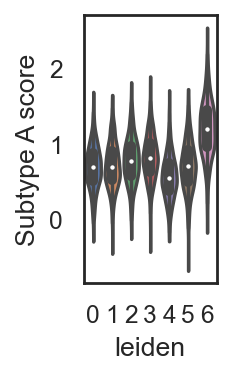

computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    230 total control genes are used. (0:00:00)


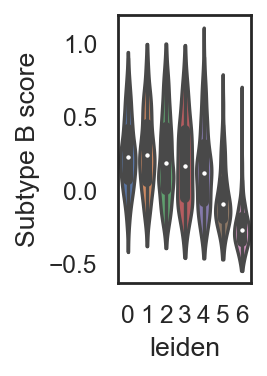

computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    306 total control genes are used. (0:00:00)


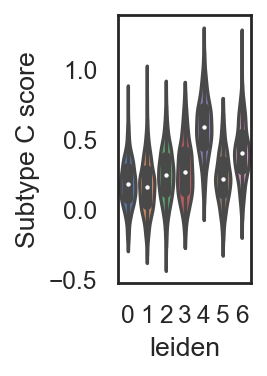

In [2]:
# reading in gene lists for gsea
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype A score')


# reading in gene lists for gsea
subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_B_genes = [x for x in subtype_B_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)


sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype B score')


# Reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# Keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)


sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')



# Plotting markers

In [4]:
# Perform Differential Gene Expression Analysis
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Extract the names of the genes
gene_names = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)

# Extract Log Fold Change values
logfc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges']).head(60)

# Filter for genes with LogFC > 1
filtered_genes = gene_names[logfc > 1].dropna()


# Extract gene names and log fold changes into a DataFrame
gene_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logfc_df = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])

# Filter for logFC > 1. This involves checking each gene's logFC across all clusters
# and selecting the gene if it has logFC > 1 in any of the clusters.
filtered_genes = gene_names_df[logfc_df > 1].stack().reset_index(level=1, drop=True).unique()

print(filtered_genes)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


In [6]:
top_genes_across_clusters = []

# Get the number of clusters
# Assuming the cluster names are integers starting from 0
num_clusters = gene_names_df.shape[1]

# Loop over each cluster to get the top 10 genes based on logFC
for cluster_idx in range(num_clusters):
    # Sort the genes in descending order by their logFC for the current cluster
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    
    # Retrieve the corresponding gene names for the top 10 logFC values
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    
    # Append these top genes to the list
    top_genes_across_clusters.extend(top_genes)

# Remove duplicates from the list, if any
top_genes_across_clusters = np.unique(top_genes_across_clusters)

print(top_genes_across_clusters)

['AK4' 'AMIGO2' 'ARHGAP28' 'ASNSP1' 'ASS1' 'BARX1' 'BASP1' 'BRIP1'
 'CASC15' 'CBLN2' 'CFAP251' 'CIBAR1' 'CIBAR1-DT' 'CLCN6' 'CLSTN2'
 'COL27A1' 'COL8A1' 'CRLF1' 'CYBA' 'DCN' 'DPYD' 'EFCAB7' 'EMP1'
 'ENSG00000231295' 'ENSG00000260658' 'ENSG00000285579' 'F2R' 'FGGY'
 'FRG1HP' 'GAL' 'GLRA3' 'H2AC6' 'HEY1' 'HMGA1P4' 'IBSP' 'IFI44' 'IGSF11'
 'ITGA11' 'KCNMB2-AS1' 'LINC01004' 'LRP1B' 'LRRN3' 'LUZP2' 'MAP2K6'
 'MARK1' 'MGLL' 'MPP4' 'NRXN1' 'NTM' 'OCLN' 'PCDH11X' 'PI15' 'PLK2'
 'PLXDC2' 'PTTG1' 'RIMS2' 'RNFT2' 'SERPINE1' 'SESN3' 'SFRP4' 'SKAP2'
 'SPP1' 'ST8SIA4' 'SULF1' 'TAC3' 'TEX14' 'VPS13B-DT' 'WFDC21P' 'ZNF704']


In [10]:
top_genes_by_cluster = {}  # Dictionary to hold top genes for each cluster

# Assuming gene_names_df and logfc_df have been correctly defined as before
num_clusters = gene_names_df.shape[1]

for cluster_idx in range(num_clusters):
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    top_genes_by_cluster[f"Cluster {cluster_idx}"] = top_genes
    

sc.pl.matrixplot(
    adata,
    top_genes_by_cluster,
    "leiden",
    #dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_19526/548304907.py:33: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_subset.var['subtype_order'] = adata_subset.var['subtype'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


<Figure size 800x640 with 0 Axes>

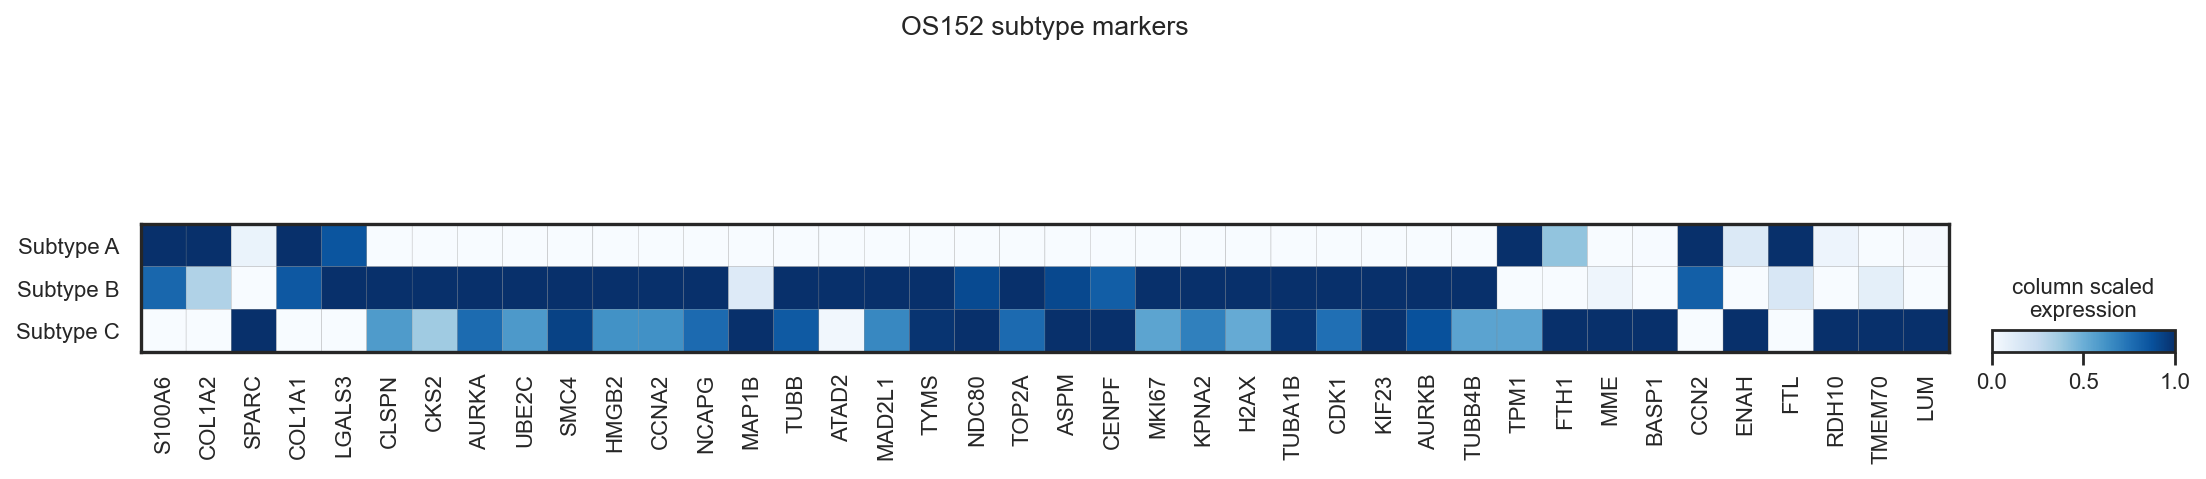

In [7]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes

Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')

# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + Subtype_B_genes + Subtype_C_genes))



# You might want to remove these missing genes from your list before plotting
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]

# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]

# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in Subtype_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}

# Annotate the genes in adata with their subtype
adata.var['subtype'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]

# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['subtype'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]

# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()

# Create a figure explicitly
plt.figure(figsize=(10, 8))  # You can adjust the size as needed

# Plotting with Scanpy on the created figure
ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='Subtype',
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS152 subtype markers",
    show=False  # Do not display the plot immediately
)

# Save the figure using matplotlib's savefig with explicit format setting
plt.savefig("/Users/brendamelano/Desktop/OS152_subtype_markers.svg", format='svg')

plt.show()

plt.close()  # Close the plot to free up memory

# Pathway enrichment analysis

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    189 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'


    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    146 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    192 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)


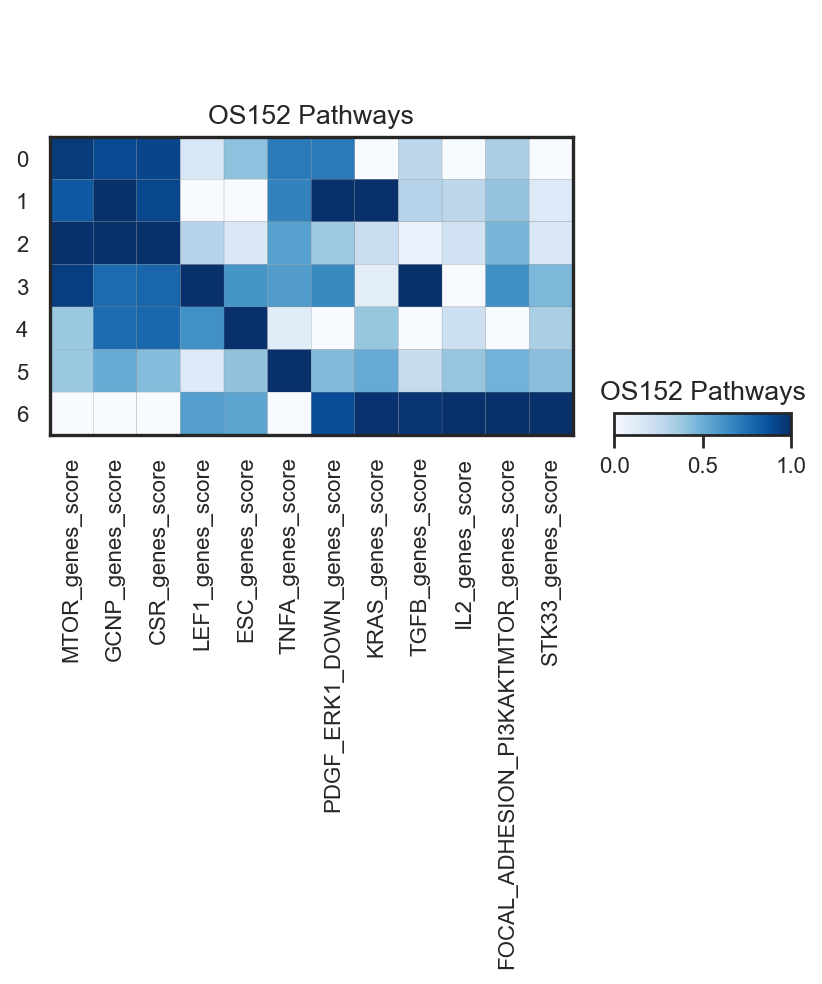

In [3]:
# Defining the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'


# Create a dictionary to store gene lists
gene_lists = {}


# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

            
# Create a dictionary to store gene scores for each module
gene_scores = {}


# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue



adata.var_names_make_unique()


# Defining the score names
scores = [ 'MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score','ESC_genes_score','TNFA_genes_score','PDGF_ERK1_DOWN_genes_score',   
          'KRAS_genes_score', 'TGFB_genes_score','IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score',]


# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "leiden",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)


# Add a title to each plot in the dictionary, or modify as needed for specific axes
for ax in axes_dict.values():
    ax.set_title('OS152 Pathways', fontsize=12)

    
# Save the figure. Ensure that all parts of the figure are on the same figure object
#plt.gcf().savefig('/Users/brendamelano/Desktop/OS152_Pathways.svg', format='svg')  # Adjust path as needed


# Show the plot if desired
plt.show()

# Subtype labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


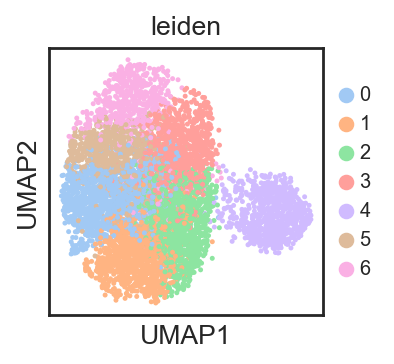

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


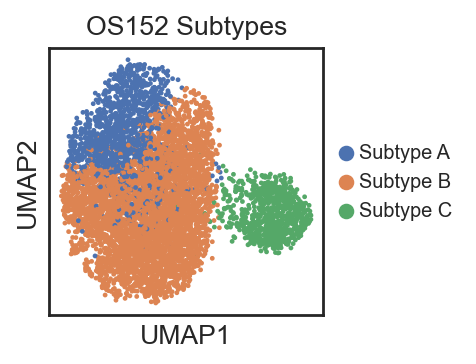

In [5]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)

adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='1']='3'
adata.obs['leiden'][adata.obs['leiden']=='0']='3'
adata.obs['leiden'][adata.obs['leiden']=='2']='3'
adata.obs['leiden'][adata.obs['leiden']=='5']='6'

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['6'],  'Subtype B': ['3'], 'Subtype C':['4']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# Creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS152 Subtypes") #, palette = subtype_colors

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_adata_subtype_PCA.h5ad")

#adata = sc.read("/Users/brendamelano/Desktop/OS152_adata_labeled.h5ad")


# scVI

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:91: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/400:   0%|                                      | 0/400 [00:00<?, ?it/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 2/400:   0%|           | 1/400 [00:01<07:02,  1.06s/it, loss=729, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 2/400:   0%|           | 2/400 [00:01<06:32,  1.02it/s, loss=677, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 3/400:   0%|           | 2/400 [00:01<06:32,  1.02it/s, loss=677, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 4/400:   1%|           | 3/400 [00:02<06:30,  1.02it/s, loss=660, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 5/400:   1%|           | 4/400 [00:03<06:22,  1.04it/s, loss=650, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 6/400:   1%|▏          | 5/400 [00:04<06:18,  1.04it/s, loss=641, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 7/400:   2%|▏          | 6/400 [00:05<06:13,  1.06it/s, loss=637, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 8/400:   2%|▏          | 7/400 [00:06<06:10,  1.06it/s, loss=635, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 9/400:   2%|▏          | 8/400 [00:07<06:06,  1.07it/s, loss=629, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 10/400:   2%|▏         | 9/400 [00:08<06:11,  1.05it/s, loss=627, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 11/400:   2%|▏        | 10/400 [00:09<06:10,  1.05it/s, loss=625, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 11/400:   3%|▏        | 11/400 [00:10<06:09,  1.05it/s, loss=622, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 12/400:   3%|▏        | 11/400 [00:10<06:09,  1.05it/s, loss=622, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 13/400:   3%|▎        | 12/400 [00:11<06:07,  1.06it/s, loss=618, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 14/400:   3%|▎        | 13/400 [00:12<06:06,  1.05it/s, loss=618, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 15/400:   4%|▎        | 14/400 [00:13<06:07,  1.05it/s, loss=614, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 16/400:   4%|▎        | 15/400 [00:14<06:06,  1.05it/s, loss=614, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 17/400:   4%|▎        | 16/400 [00:15<06:04,  1.05it/s, loss=611, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 17/400:   4%|▍        | 17/400 [00:16<06:03,  1.05it/s, loss=608, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 18/400:   4%|▍        | 17/400 [00:16<06:03,  1.05it/s, loss=608, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 19/400:   4%|▍        | 18/400 [00:17<06:04,  1.05it/s, loss=609, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 20/400:   5%|▍        | 19/400 [00:18<06:02,  1.05it/s, loss=607, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 21/400:   5%|▍        | 20/400 [00:19<06:00,  1.05it/s, loss=606, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 22/400:   5%|▍        | 21/400 [00:20<05:59,  1.06it/s, loss=602, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 23/400:   6%|▍        | 22/400 [00:20<05:57,  1.06it/s, loss=603, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 24/400:   6%|▌        | 23/400 [00:21<05:57,  1.05it/s, loss=598, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 25/400:   6%|▌        | 24/400 [00:22<05:57,  1.05it/s, loss=599, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 26/400:   6%|▌        | 25/400 [00:23<05:55,  1.05it/s, loss=597, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 27/400:   6%|▌        | 26/400 [00:24<05:53,  1.06it/s, loss=597, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 28/400:   7%|▌        | 27/400 [00:25<05:53,  1.06it/s, loss=594, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 29/400:   7%|▋        | 28/400 [00:26<05:51,  1.06it/s, loss=594, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 30/400:   7%|▋        | 29/400 [00:27<05:56,  1.04it/s, loss=592, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 31/400:   8%|▋        | 30/400 [00:28<05:55,  1.04it/s, loss=591, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 32/400:   8%|▋        | 31/400 [00:29<05:55,  1.04it/s, loss=591, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 33/400:   8%|▋        | 32/400 [00:30<05:52,  1.04it/s, loss=590, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 34/400:   8%|▋        | 33/400 [00:31<05:51,  1.05it/s, loss=589, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 35/400:   8%|▊        | 34/400 [00:32<05:47,  1.05it/s, loss=589, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 36/400:   9%|▊        | 35/400 [00:33<06:03,  1.00it/s, loss=588, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 36/400:   9%|▊        | 36/400 [00:34<06:06,  1.01s/it, loss=588, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 37/400:   9%|▊        | 36/400 [00:34<06:06,  1.01s/it, loss=586, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 38/400:   9%|▊        | 37/400 [00:35<05:53,  1.03it/s, loss=585, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 39/400:  10%|▊        | 38/400 [00:36<05:44,  1.05it/s, loss=585, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 40/400:  10%|▉        | 39/400 [00:37<05:37,  1.07it/s, loss=582, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 41/400:  10%|▉        | 40/400 [00:38<05:33,  1.08it/s, loss=583, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 41/400:  10%|▉        | 41/400 [00:39<05:28,  1.09it/s, loss=583, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 42/400:  10%|▉        | 41/400 [00:39<05:28,  1.09it/s, loss=581, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 43/400:  10%|▉        | 42/400 [00:39<05:26,  1.10it/s, loss=582, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 44/400:  11%|▉        | 43/400 [00:40<05:26,  1.09it/s, loss=580, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 45/400:  11%|▉        | 44/400 [00:41<05:30,  1.08it/s, loss=581, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 46/400:  11%|█        | 45/400 [00:42<05:29,  1.08it/s, loss=580, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 47/400:  12%|█        | 46/400 [00:43<05:31,  1.07it/s, loss=579, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 48/400:  12%|█        | 47/400 [00:44<05:33,  1.06it/s, loss=578, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 49/400:  12%|█        | 48/400 [00:45<05:33,  1.06it/s, loss=577, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 50/400:  12%|█        | 49/400 [00:46<05:31,  1.06it/s, loss=578, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 51/400:  12%|█▏       | 50/400 [00:47<05:29,  1.06it/s, loss=576, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 52/400:  13%|█▏       | 51/400 [00:48<05:28,  1.06it/s, loss=576, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 53/400:  13%|█▏       | 52/400 [00:49<05:26,  1.07it/s, loss=575, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 54/400:  13%|█▏       | 53/400 [00:50<05:24,  1.07it/s, loss=575, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 55/400:  14%|█▏       | 54/400 [00:51<05:24,  1.07it/s, loss=576, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 56/400:  14%|█▏       | 55/400 [00:52<05:22,  1.07it/s, loss=573, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 57/400:  14%|█▎       | 56/400 [00:53<05:21,  1.07it/s, loss=574, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 58/400:  14%|█▎       | 57/400 [00:54<05:20,  1.07it/s, loss=573, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 59/400:  14%|█▎       | 58/400 [00:54<05:19,  1.07it/s, loss=572, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 60/400:  15%|█▎       | 59/400 [00:55<05:17,  1.07it/s, loss=571, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 61/400:  15%|█▎       | 60/400 [00:56<05:16,  1.07it/s, loss=572, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 62/400:  15%|█▎       | 61/400 [00:57<05:16,  1.07it/s, loss=572, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 63/400:  16%|█▍       | 62/400 [00:58<05:16,  1.07it/s, loss=573, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 64/400:  16%|█▍       | 63/400 [00:59<05:15,  1.07it/s, loss=571, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 65/400:  16%|█▍       | 64/400 [01:00<05:14,  1.07it/s, loss=571, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 66/400:  16%|█▍       | 65/400 [01:01<05:13,  1.07it/s, loss=570, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 67/400:  16%|█▍       | 66/400 [01:02<05:11,  1.07it/s, loss=569, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 68/400:  17%|█▌       | 67/400 [01:03<05:10,  1.07it/s, loss=569, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 69/400:  17%|█▌       | 68/400 [01:04<05:09,  1.07it/s, loss=569, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 70/400:  17%|█▌       | 69/400 [01:05<05:08,  1.07it/s, loss=569, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 71/400:  18%|█▌       | 70/400 [01:06<05:08,  1.07it/s, loss=568, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 72/400:  18%|█▌       | 71/400 [01:07<05:07,  1.07it/s, loss=567, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 73/400:  18%|█▌       | 72/400 [01:08<05:06,  1.07it/s, loss=568, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 74/400:  18%|█▋       | 73/400 [01:08<05:06,  1.07it/s, loss=567, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 75/400:  18%|█▋       | 74/400 [01:09<05:06,  1.07it/s, loss=567, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 76/400:  19%|█▋       | 75/400 [01:10<05:04,  1.07it/s, loss=566, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 77/400:  19%|█▋       | 76/400 [01:11<05:03,  1.07it/s, loss=567, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 78/400:  19%|█▋       | 77/400 [01:12<05:01,  1.07it/s, loss=567, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 79/400:  20%|█▊       | 78/400 [01:13<05:01,  1.07it/s, loss=566, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 80/400:  20%|█▊       | 79/400 [01:14<04:59,  1.07it/s, loss=565, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 81/400:  20%|█▊       | 80/400 [01:15<04:59,  1.07it/s, loss=564, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 82/400:  20%|█▊       | 81/400 [01:16<04:57,  1.07it/s, loss=565, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 83/400:  20%|█▊       | 82/400 [01:17<04:56,  1.07it/s, loss=565, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 84/400:  21%|█▊       | 83/400 [01:18<04:54,  1.08it/s, loss=565, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 85/400:  21%|█▉       | 84/400 [01:19<04:53,  1.08it/s, loss=565, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 86/400:  21%|█▉       | 85/400 [01:20<04:52,  1.08it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 87/400:  22%|█▉       | 86/400 [01:21<04:50,  1.08it/s, loss=564, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 88/400:  22%|█▉       | 87/400 [01:22<04:50,  1.08it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 89/400:  22%|█▉       | 88/400 [01:22<04:49,  1.08it/s, loss=564, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 90/400:  22%|██       | 89/400 [01:23<04:47,  1.08it/s, loss=562, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 91/400:  22%|██       | 90/400 [01:24<04:46,  1.08it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 92/400:  23%|██       | 91/400 [01:25<04:46,  1.08it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 93/400:  23%|██       | 92/400 [01:26<04:45,  1.08it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 94/400:  23%|██       | 93/400 [01:27<04:46,  1.07it/s, loss=564, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 95/400:  24%|██       | 94/400 [01:28<04:46,  1.07it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 96/400:  24%|██▏      | 95/400 [01:29<04:45,  1.07it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 97/400:  24%|██▏      | 96/400 [01:30<04:45,  1.07it/s, loss=563, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 98/400:  24%|██▏      | 97/400 [01:31<04:43,  1.07it/s, loss=562, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 99/400:  24%|██▏      | 98/400 [01:32<04:41,  1.07it/s, loss=562, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 100/400:  25%|█▉      | 99/400 [01:33<04:43,  1.06it/s, loss=562, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 101/400:  25%|█▊     | 100/400 [01:34<04:41,  1.06it/s, loss=561, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 102/400:  25%|█▊     | 101/400 [01:35<04:40,  1.07it/s, loss=562, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 103/400:  26%|█▊     | 102/400 [01:36<04:38,  1.07it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 104/400:  26%|█▊     | 103/400 [01:36<04:36,  1.07it/s, loss=562, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 105/400:  26%|█▊     | 104/400 [01:37<04:38,  1.06it/s, loss=561, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 106/400:  26%|█▊     | 105/400 [01:38<04:37,  1.06it/s, loss=561, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 107/400:  26%|█▊     | 106/400 [01:39<04:34,  1.07it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 108/400:  27%|█▊     | 107/400 [01:40<04:33,  1.07it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 109/400:  27%|█▉     | 108/400 [01:41<04:32,  1.07it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 110/400:  27%|█▉     | 109/400 [01:42<04:31,  1.07it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 111/400:  28%|█▉     | 110/400 [01:43<04:39,  1.04it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 112/400:  28%|█▉     | 111/400 [01:44<04:35,  1.05it/s, loss=561, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 113/400:  28%|█▉     | 112/400 [01:45<04:32,  1.06it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 114/400:  28%|█▉     | 113/400 [01:46<04:30,  1.06it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 115/400:  28%|█▉     | 114/400 [01:47<04:28,  1.07it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 116/400:  29%|██     | 115/400 [01:48<04:30,  1.05it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 117/400:  29%|██     | 116/400 [01:49<04:28,  1.06it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 118/400:  29%|██     | 117/400 [01:50<04:25,  1.06it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 119/400:  30%|██     | 118/400 [01:51<04:23,  1.07it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 120/400:  30%|██     | 119/400 [01:52<04:22,  1.07it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 121/400:  30%|██     | 120/400 [01:52<04:22,  1.07it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 122/400:  30%|██     | 121/400 [01:53<04:21,  1.07it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 123/400:  30%|██▏    | 122/400 [01:54<04:21,  1.06it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 124/400:  31%|██▏    | 123/400 [01:55<04:22,  1.06it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 125/400:  31%|██▏    | 124/400 [01:56<04:19,  1.06it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 126/400:  31%|██▏    | 125/400 [01:57<04:17,  1.07it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 127/400:  32%|██▏    | 126/400 [01:58<04:18,  1.06it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 128/400:  32%|██▏    | 127/400 [01:59<04:16,  1.06it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 129/400:  32%|██▏    | 128/400 [02:00<04:14,  1.07it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 130/400:  32%|██▎    | 129/400 [02:01<04:12,  1.07it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 131/400:  32%|██▎    | 130/400 [02:02<04:11,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 132/400:  33%|██▎    | 131/400 [02:03<04:09,  1.08it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 133/400:  33%|██▎    | 132/400 [02:04<04:09,  1.07it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 134/400:  33%|██▎    | 133/400 [02:05<04:08,  1.08it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 135/400:  34%|██▎    | 134/400 [02:06<04:07,  1.08it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 136/400:  34%|██▎    | 135/400 [02:06<04:06,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 137/400:  34%|██▍    | 136/400 [02:07<04:04,  1.08it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 138/400:  34%|██▍    | 137/400 [02:08<04:03,  1.08it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 139/400:  34%|██▍    | 138/400 [02:09<04:01,  1.08it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 140/400:  35%|██▍    | 139/400 [02:10<04:00,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 141/400:  35%|██▍    | 140/400 [02:11<03:59,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 142/400:  35%|██▍    | 141/400 [02:12<03:57,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 143/400:  36%|██▍    | 142/400 [02:13<03:57,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 144/400:  36%|██▌    | 143/400 [02:14<03:55,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 145/400:  36%|██▌    | 144/400 [02:15<03:55,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 146/400:  36%|██▌    | 145/400 [02:16<03:54,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 147/400:  36%|██▌    | 146/400 [02:17<03:53,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 148/400:  37%|██▌    | 147/400 [02:18<04:00,  1.05it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 149/400:  37%|██▌    | 148/400 [02:19<03:56,  1.06it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 150/400:  37%|██▌    | 149/400 [02:19<03:54,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 151/400:  38%|██▋    | 150/400 [02:20<03:53,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 152/400:  38%|██▋    | 151/400 [02:21<03:49,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 153/400:  38%|██▋    | 152/400 [02:22<03:48,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 154/400:  38%|██▋    | 153/400 [02:23<03:46,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 155/400:  38%|██▋    | 154/400 [02:24<03:44,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 156/400:  39%|██▋    | 155/400 [02:25<03:42,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 157/400:  39%|██▋    | 156/400 [02:26<03:43,  1.09it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 158/400:  39%|██▋    | 157/400 [02:27<03:43,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 159/400:  40%|██▊    | 158/400 [02:28<03:44,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 160/400:  40%|██▊    | 159/400 [02:29<03:44,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 161/400:  40%|██▊    | 160/400 [02:30<03:43,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 162/400:  40%|██▊    | 161/400 [02:30<03:41,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 163/400:  40%|██▊    | 162/400 [02:31<03:41,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 164/400:  41%|██▊    | 163/400 [02:32<03:40,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 165/400:  41%|██▊    | 164/400 [02:33<03:39,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 166/400:  41%|██▉    | 165/400 [02:34<03:38,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 167/400:  42%|██▉    | 166/400 [02:35<03:36,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 168/400:  42%|██▉    | 167/400 [02:36<03:35,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 169/400:  42%|██▉    | 168/400 [02:37<03:34,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 170/400:  42%|██▉    | 169/400 [02:38<03:33,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 171/400:  42%|██▉    | 170/400 [02:39<03:33,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 172/400:  43%|██▉    | 171/400 [02:40<03:32,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 173/400:  43%|███    | 172/400 [02:41<03:30,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 174/400:  43%|███    | 173/400 [02:42<03:29,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 175/400:  44%|███    | 174/400 [02:43<03:28,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 176/400:  44%|███    | 175/400 [02:43<03:29,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 177/400:  44%|███    | 176/400 [02:44<03:30,  1.06it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 178/400:  44%|███    | 177/400 [02:45<03:30,  1.06it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 179/400:  44%|███    | 178/400 [02:46<03:28,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 180/400:  45%|███▏   | 179/400 [02:47<03:26,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 181/400:  45%|███▏   | 180/400 [02:48<03:24,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 182/400:  45%|███▏   | 181/400 [02:49<03:23,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 183/400:  46%|███▏   | 182/400 [02:50<03:21,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 184/400:  46%|███▏   | 183/400 [02:51<03:20,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 185/400:  46%|███▏   | 184/400 [02:52<03:19,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 186/400:  46%|███▏   | 185/400 [02:53<03:18,  1.08it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 187/400:  46%|███▎   | 186/400 [02:54<03:21,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 188/400:  47%|███▎   | 187/400 [02:55<03:19,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 189/400:  47%|███▎   | 188/400 [02:56<03:17,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 190/400:  47%|███▎   | 189/400 [02:57<03:15,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 191/400:  48%|███▎   | 190/400 [02:57<03:14,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 192/400:  48%|███▎   | 191/400 [02:58<03:12,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 193/400:  48%|███▎   | 192/400 [02:59<03:11,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 194/400:  48%|███▍   | 193/400 [03:00<03:10,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 195/400:  48%|███▍   | 194/400 [03:01<03:09,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 196/400:  49%|███▍   | 195/400 [03:02<03:08,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 197/400:  49%|███▍   | 196/400 [03:03<03:08,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 198/400:  49%|███▍   | 197/400 [03:04<03:08,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 199/400:  50%|███▍   | 198/400 [03:05<03:08,  1.07it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 200/400:  50%|███▍   | 199/400 [03:06<03:07,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 201/400:  50%|███▌   | 200/400 [03:07<03:06,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 202/400:  50%|███▌   | 201/400 [03:08<03:05,  1.07it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 203/400:  50%|███▌   | 202/400 [03:09<03:03,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 204/400:  51%|███▌   | 203/400 [03:09<03:02,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 205/400:  51%|███▌   | 204/400 [03:10<03:02,  1.07it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 206/400:  51%|███▌   | 205/400 [03:11<03:00,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 207/400:  52%|███▌   | 206/400 [03:12<02:59,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 208/400:  52%|███▌   | 207/400 [03:13<02:59,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 209/400:  52%|███▋   | 208/400 [03:14<02:57,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 210/400:  52%|███▋   | 209/400 [03:15<02:56,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 211/400:  52%|███▋   | 210/400 [03:16<02:54,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 212/400:  53%|███▋   | 211/400 [03:17<02:53,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 213/400:  53%|███▋   | 212/400 [03:18<02:51,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 214/400:  53%|███▋   | 213/400 [03:19<02:50,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 215/400:  54%|███▋   | 214/400 [03:20<02:49,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 216/400:  54%|███▊   | 215/400 [03:20<02:48,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 217/400:  54%|███▊   | 216/400 [03:21<02:48,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 218/400:  54%|███▊   | 217/400 [03:22<02:47,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 219/400:  55%|███▊   | 218/400 [03:23<02:47,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 220/400:  55%|███▊   | 219/400 [03:24<02:46,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 221/400:  55%|███▊   | 220/400 [03:25<02:45,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 222/400:  55%|███▊   | 221/400 [03:26<02:44,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 223/400:  56%|███▉   | 222/400 [03:27<02:46,  1.07it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 224/400:  56%|███▉   | 223/400 [03:28<02:44,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 225/400:  56%|███▉   | 224/400 [03:29<02:42,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 226/400:  56%|███▉   | 225/400 [03:30<02:43,  1.07it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 227/400:  56%|███▉   | 226/400 [03:31<02:42,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 228/400:  57%|███▉   | 227/400 [03:32<02:40,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 229/400:  57%|███▉   | 228/400 [03:33<02:39,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 230/400:  57%|████   | 229/400 [03:34<02:40,  1.07it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 231/400:  57%|████   | 230/400 [03:34<02:40,  1.06it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 232/400:  58%|████   | 231/400 [03:35<02:37,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 233/400:  58%|████   | 232/400 [03:36<02:36,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 234/400:  58%|████   | 233/400 [03:37<02:34,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 235/400:  58%|████   | 234/400 [03:38<02:32,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 236/400:  59%|████   | 235/400 [03:39<02:31,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 237/400:  59%|████▏  | 236/400 [03:40<02:30,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 238/400:  59%|████▏  | 237/400 [03:41<02:31,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 239/400:  60%|████▏  | 238/400 [03:42<02:29,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 240/400:  60%|████▏  | 239/400 [03:43<02:28,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 241/400:  60%|████▏  | 240/400 [03:44<02:27,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 242/400:  60%|████▏  | 241/400 [03:45<02:27,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 243/400:  60%|████▏  | 242/400 [03:46<02:25,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 244/400:  61%|████▎  | 243/400 [03:46<02:24,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 245/400:  61%|████▎  | 244/400 [03:47<02:25,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 246/400:  61%|████▎  | 245/400 [03:48<02:23,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 247/400:  62%|████▎  | 246/400 [03:49<02:22,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 248/400:  62%|████▎  | 247/400 [03:50<02:20,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 249/400:  62%|████▎  | 248/400 [03:51<02:20,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 250/400:  62%|████▎  | 249/400 [03:52<02:18,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 251/400:  62%|████▍  | 250/400 [03:53<02:17,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 252/400:  63%|████▍  | 251/400 [03:54<02:16,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 253/400:  63%|████▍  | 252/400 [03:55<02:16,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 254/400:  63%|████▍  | 253/400 [03:56<02:20,  1.04it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 255/400:  64%|████▍  | 254/400 [03:57<02:17,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 256/400:  64%|████▍  | 255/400 [03:58<02:13,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 257/400:  64%|████▍  | 256/400 [03:58<02:12,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 258/400:  64%|████▍  | 257/400 [03:59<02:12,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 259/400:  64%|████▌  | 258/400 [04:00<02:11,  1.08it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 260/400:  65%|████▌  | 259/400 [04:01<02:10,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 261/400:  65%|████▌  | 260/400 [04:02<02:09,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 262/400:  65%|████▌  | 261/400 [04:03<02:08,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 263/400:  66%|████▌  | 262/400 [04:04<02:06,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 264/400:  66%|████▌  | 263/400 [04:05<02:05,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 265/400:  66%|████▌  | 264/400 [04:06<02:05,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 266/400:  66%|████▋  | 265/400 [04:07<02:03,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 267/400:  66%|████▋  | 266/400 [04:08<02:02,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 268/400:  67%|████▋  | 267/400 [04:09<02:01,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 269/400:  67%|████▋  | 268/400 [04:09<02:00,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 270/400:  67%|████▋  | 269/400 [04:10<02:00,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 271/400:  68%|████▋  | 270/400 [04:11<01:58,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 272/400:  68%|████▋  | 271/400 [04:12<01:57,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 273/400:  68%|████▊  | 272/400 [04:13<01:56,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 274/400:  68%|████▊  | 273/400 [04:14<01:55,  1.10it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 275/400:  68%|████▊  | 274/400 [04:15<01:55,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 276/400:  69%|████▊  | 275/400 [04:16<01:54,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 277/400:  69%|████▊  | 276/400 [04:17<01:53,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 278/400:  69%|████▊  | 277/400 [04:18<01:52,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 279/400:  70%|████▊  | 278/400 [04:19<01:51,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 280/400:  70%|████▉  | 279/400 [04:20<01:50,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 281/400:  70%|████▉  | 280/400 [04:20<01:49,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 282/400:  70%|████▉  | 281/400 [04:21<01:48,  1.10it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 283/400:  70%|████▉  | 282/400 [04:22<01:47,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 284/400:  71%|████▉  | 283/400 [04:23<01:46,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 285/400:  71%|████▉  | 284/400 [04:24<01:45,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 286/400:  71%|████▉  | 285/400 [04:25<01:44,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 287/400:  72%|█████  | 286/400 [04:26<01:44,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 288/400:  72%|█████  | 287/400 [04:27<01:43,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 289/400:  72%|█████  | 288/400 [04:28<01:43,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 290/400:  72%|█████  | 289/400 [04:29<01:41,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 291/400:  72%|█████  | 290/400 [04:30<01:40,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 292/400:  73%|█████  | 291/400 [04:30<01:39,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 293/400:  73%|█████  | 292/400 [04:31<01:38,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 294/400:  73%|█████▏ | 293/400 [04:32<01:37,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 295/400:  74%|█████▏ | 294/400 [04:33<01:39,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 296/400:  74%|█████▏ | 295/400 [04:34<01:38,  1.06it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 297/400:  74%|█████▏ | 296/400 [04:35<01:37,  1.06it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 298/400:  74%|█████▏ | 297/400 [04:36<01:36,  1.07it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 299/400:  74%|█████▏ | 298/400 [04:37<01:34,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 300/400:  75%|█████▏ | 299/400 [04:38<01:33,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 301/400:  75%|█████▎ | 300/400 [04:39<01:32,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 302/400:  75%|█████▎ | 301/400 [04:40<01:31,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 303/400:  76%|█████▎ | 302/400 [04:41<01:30,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 304/400:  76%|█████▎ | 303/400 [04:42<01:29,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 305/400:  76%|█████▎ | 304/400 [04:43<01:27,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 306/400:  76%|█████▎ | 305/400 [04:43<01:27,  1.08it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 307/400:  76%|█████▎ | 306/400 [04:44<01:28,  1.06it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 308/400:  77%|█████▎ | 307/400 [04:45<01:27,  1.06it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 309/400:  77%|█████▍ | 308/400 [04:46<01:26,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 310/400:  77%|█████▍ | 309/400 [04:47<01:25,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 311/400:  78%|█████▍ | 310/400 [04:48<01:23,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 312/400:  78%|█████▍ | 311/400 [04:49<01:22,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 313/400:  78%|█████▍ | 312/400 [04:50<01:23,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 314/400:  78%|█████▍ | 313/400 [04:51<01:21,  1.07it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 315/400:  78%|█████▍ | 314/400 [04:52<01:21,  1.05it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 316/400:  79%|█████▌ | 315/400 [04:53<01:20,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 317/400:  79%|█████▌ | 316/400 [04:54<01:19,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 318/400:  79%|█████▌ | 317/400 [04:55<01:22,  1.01it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 319/400:  80%|█████▌ | 318/400 [04:56<01:22,  1.01s/it, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 320/400:  80%|█████▌ | 319/400 [04:57<01:21,  1.00s/it, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 321/400:  80%|█████▌ | 320/400 [04:58<01:17,  1.04it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 322/400:  80%|█████▌ | 321/400 [04:59<01:15,  1.05it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 322/400:  80%|█████▋ | 322/400 [05:00<01:14,  1.05it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 323/400:  80%|█████▋ | 322/400 [05:00<01:14,  1.05it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 324/400:  81%|█████▋ | 323/400 [05:01<01:12,  1.06it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 325/400:  81%|█████▋ | 324/400 [05:02<01:10,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 326/400:  81%|█████▋ | 325/400 [05:02<01:09,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 327/400:  82%|█████▋ | 326/400 [05:03<01:07,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 328/400:  82%|█████▋ | 327/400 [05:04<01:06,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 329/400:  82%|█████▋ | 328/400 [05:05<01:05,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 330/400:  82%|█████▊ | 329/400 [05:06<01:03,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 331/400:  82%|█████▊ | 330/400 [05:07<01:04,  1.08it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 332/400:  83%|█████▊ | 331/400 [05:08<01:03,  1.09it/s, loss=555, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 333/400:  83%|█████▊ | 332/400 [05:09<01:03,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 334/400:  83%|█████▊ | 333/400 [05:10<01:02,  1.07it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 335/400:  84%|█████▊ | 334/400 [05:11<01:01,  1.08it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 336/400:  84%|█████▊ | 335/400 [05:12<01:00,  1.08it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 337/400:  84%|█████▉ | 336/400 [05:13<00:58,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 338/400:  84%|█████▉ | 337/400 [05:14<00:58,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 339/400:  84%|█████▉ | 338/400 [05:14<00:56,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 340/400:  85%|█████▉ | 339/400 [05:15<00:55,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 341/400:  85%|█████▉ | 340/400 [05:16<00:54,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 342/400:  85%|█████▉ | 341/400 [05:17<00:53,  1.10it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 343/400:  86%|█████▉ | 342/400 [05:18<00:52,  1.10it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 344/400:  86%|██████ | 343/400 [05:19<00:51,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 345/400:  86%|██████ | 344/400 [05:20<00:50,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 346/400:  86%|██████ | 345/400 [05:21<00:50,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 347/400:  86%|██████ | 346/400 [05:22<00:48,  1.11it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 348/400:  87%|██████ | 347/400 [05:23<00:47,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 349/400:  87%|██████ | 348/400 [05:23<00:46,  1.11it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 350/400:  87%|██████ | 349/400 [05:24<00:46,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 351/400:  88%|██████▏| 350/400 [05:25<00:45,  1.10it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 352/400:  88%|██████▏| 351/400 [05:26<00:45,  1.09it/s, loss=556, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 353/400:  88%|██████▏| 352/400 [05:27<00:45,  1.05it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 354/400:  88%|██████▏| 353/400 [05:28<00:45,  1.03it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 354/400:  88%|██████▏| 354/400 [05:29<00:44,  1.04it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 355/400:  88%|██████▏| 354/400 [05:29<00:44,  1.04it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 356/400:  89%|██████▏| 355/400 [05:30<00:42,  1.06it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 357/400:  89%|██████▏| 356/400 [05:31<00:40,  1.08it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 358/400:  89%|██████▏| 357/400 [05:32<00:39,  1.09it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 359/400:  90%|██████▎| 358/400 [05:33<00:38,  1.09it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 360/400:  90%|██████▎| 359/400 [05:34<00:37,  1.10it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 361/400:  90%|██████▎| 360/400 [05:35<00:36,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 362/400:  90%|██████▎| 361/400 [05:35<00:34,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 363/400:  90%|██████▎| 362/400 [05:36<00:33,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 364/400:  91%|██████▎| 363/400 [05:37<00:32,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 365/400:  91%|██████▎| 364/400 [05:38<00:31,  1.13it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 366/400:  91%|██████▍| 365/400 [05:39<00:30,  1.14it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 367/400:  92%|██████▍| 366/400 [05:40<00:30,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 368/400:  92%|██████▍| 367/400 [05:41<00:29,  1.13it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 368/400:  92%|██████▍| 368/400 [05:42<00:28,  1.13it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 369/400:  92%|██████▍| 368/400 [05:42<00:28,  1.13it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 370/400:  92%|██████▍| 369/400 [05:43<00:27,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 371/400:  92%|██████▍| 370/400 [05:43<00:26,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 372/400:  93%|██████▍| 371/400 [05:44<00:25,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 373/400:  93%|██████▌| 372/400 [05:45<00:24,  1.13it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 374/400:  93%|██████▌| 373/400 [05:46<00:23,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 375/400:  94%|██████▌| 374/400 [05:47<00:22,  1.13it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 376/400:  94%|██████▌| 375/400 [05:48<00:22,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 377/400:  94%|██████▌| 376/400 [05:49<00:21,  1.13it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 378/400:  94%|██████▌| 377/400 [05:50<00:20,  1.14it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 379/400:  94%|██████▌| 378/400 [05:50<00:19,  1.14it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 380/400:  95%|██████▋| 379/400 [05:51<00:18,  1.14it/s, loss=560, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 381/400:  95%|██████▋| 380/400 [05:52<00:17,  1.12it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 382/400:  95%|██████▋| 381/400 [05:53<00:16,  1.13it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 383/400:  96%|██████▋| 382/400 [05:54<00:16,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 384/400:  96%|██████▋| 383/400 [05:55<00:15,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 385/400:  96%|██████▋| 384/400 [05:56<00:14,  1.12it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 386/400:  96%|██████▋| 385/400 [05:57<00:13,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 387/400:  96%|██████▊| 386/400 [05:58<00:12,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 388/400:  97%|██████▊| 387/400 [05:59<00:11,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 389/400:  97%|██████▊| 388/400 [05:59<00:10,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 390/400:  97%|██████▊| 389/400 [06:00<00:09,  1.11it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 391/400:  98%|██████▊| 390/400 [06:01<00:08,  1.11it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 392/400:  98%|██████▊| 391/400 [06:02<00:08,  1.11it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 393/400:  98%|██████▊| 392/400 [06:03<00:07,  1.12it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 394/400:  98%|██████▉| 393/400 [06:04<00:06,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 395/400:  98%|██████▉| 394/400 [06:05<00:05,  1.11it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 396/400:  99%|██████▉| 395/400 [06:06<00:04,  1.12it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 397/400:  99%|██████▉| 396/400 [06:07<00:03,  1.12it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 398/400:  99%|██████▉| 397/400 [06:08<00:02,  1.09it/s, loss=559, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 399/400: 100%|██████▉| 398/400 [06:09<00:01,  1.06it/s, loss=558, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 400/400: 100%|██████▉| 399/400 [06:09<00:00,  1.07it/s, loss=557, v_num=1]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:482: UserWarning: The value argument must be within the support of the distributi

Epoch 400/400: 100%|███████| 400/400 [06:10<00:00,  1.09it/s, loss=558, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [06:10<00:00,  1.08it/s, loss=558, v_num=1]
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


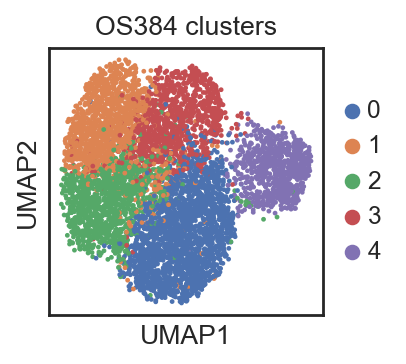

In [2]:
adata = adata.copy()


# setting up the anndata object to include categorical and continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["pct_counts_mt", "ccdifference"]
)

# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

# reading in the adata file from the data integration script
#adata = scvi.read("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# saving my model
#model.save("OS384_scvi_model/")

# loading the model
#model = scvi.model.SCVI.load("OS384_scvi_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()


# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent


# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)


# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True,
    title = 'OS384 clusters'#,
    #save = "OS384_LT_umap.svg"
)


# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)


# Define the number of clusters
n_clusters = len(clusters[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)


# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# RNA velocity

computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/283 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:03:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/6490 [00:00<?, ?cells/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


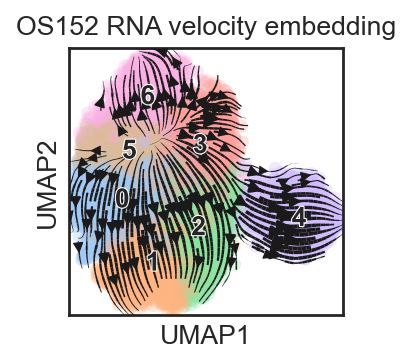

In [4]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)


# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)


# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)


# Define the number of clusters
n_clusters = len(clusters[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)


# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]


# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 palette=colors, 
                                 title = 'OS152 RNA velocity embedding',
                                 frameon = True)

saving figure to file ./figures/scvelo_velocity_embedding_stream.svg


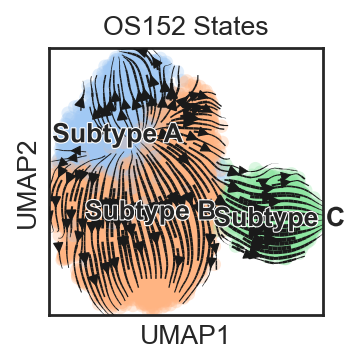

In [6]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, 
                                 basis='umap', 
                                 color='Subtype', 
                                 palette=colors, 
                                 title='OS152 States',
                                 frameon=True,
                                 save='velocity_embedding_stream.svg')

# Subtype pathway enrichment analysis

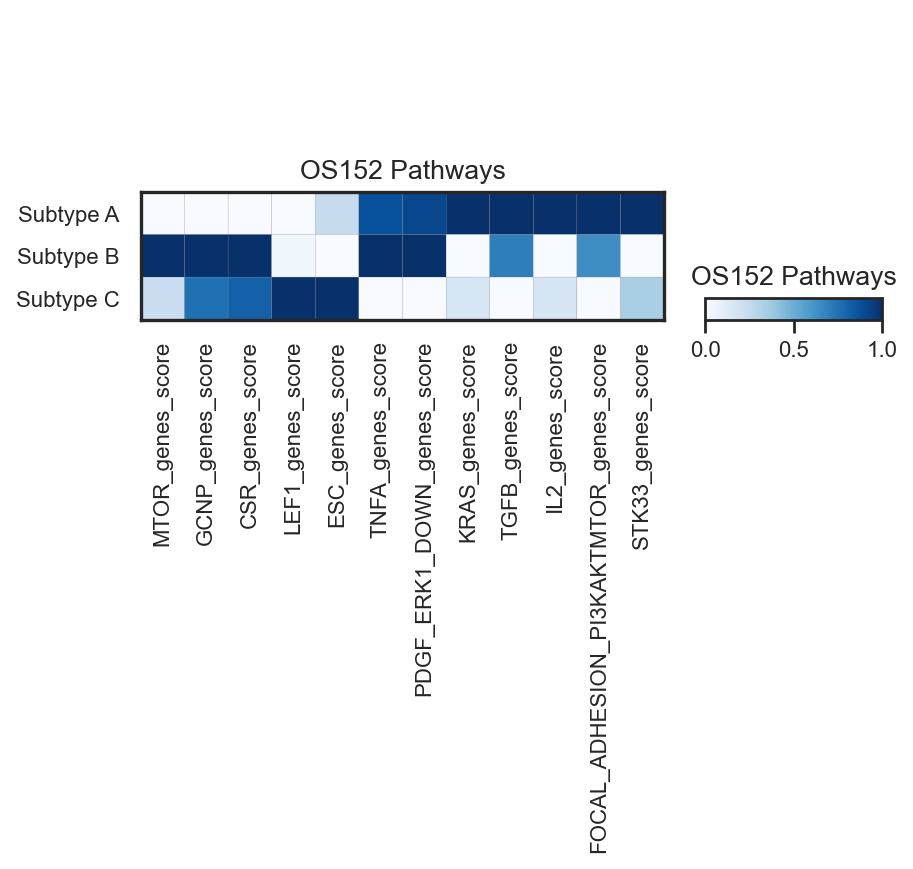

In [6]:
# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "Subtype",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)


# Add a title to each plot in the dictionary, or modify as needed for specific axes
for ax in axes_dict.values():
    ax.set_title('OS152 Pathways', fontsize=12)

    
# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS152_Pathways.svg', format='svg')  # Adjust path as needed


# Show the plot if desired
plt.show()

# Chis-squared analysis for cell cycle

In [28]:
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=True,
    title = 'OS152 Cell Cycle classification'
)

sc.pl.violin(adata, ['angiogenic_score'], groupby='Subtype', stripplot=False, inner='box', title = 'Subtype A enrichment in clusters', ylabel = 'Angiogenic Score')


# Small constant to avoid zero counts in the contingency table
epsilon = 1e-5
obs_data = adata.obs

# Create a contingency table
# Rows: depleted_10X status (True/False)
# Columns: Inside or outside cluster 3
contingency_table = pd.DataFrame(
    [
        [
            ((obs_data['phase'] == 'G1') & (obs_data['Subtype'] == 'Subtype A')).sum(),  # True in cluster 3
            ((obs_data['phase'] == 'G1') & (obs_data['Subtype'] != 'Subtype A')).sum(),  # True outside cluster 3
        ],
        [
            ((obs_data['phase'] != 'G1') & (obs_data['Subtype'] == 'Subtype A')).sum(),  # False in cluster 3
            ((obs_data['phase'] != 'G1') & (obs_data['Subtype'] != 'Subtype A')).sum(),  # False outside cluster 3
        ],
    ],
    index=["Phase_G1", "Phase_other"],
    columns=["Subtype A", "Other subtype"]
)

chi2, p, _, _ = chi2_contingency(contingency_table)


# If your data needs a small constant to be added to avoid issues with zeros, you can add it here
epsilon = 1e-10  # Or whatever small number is appropriate for your dataset
contingency_table += epsilon

# Perform chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Set a significance threshold (e.g., 0.05)
significance_threshold = 0.05

# Check if the result is significant
is_significant = p < significance_threshold

print(contingency_table)
print(f"Chi2: {chi2}")
print(f"P-value: {p}")
print(f"Significant: {'Yes' if is_significant else 'No'}")

# Assuming 'barcode_data' is your DataFrame and 'depleted_10X' and 'leiden_scVI' are columns
# Calculate the proportions
Subtype_A_G1 = obs_data[(obs_data['Subtype'] == 'Subtype A') & (obs_data['phase'] == 'G1')]
Subtype_A_all = obs_data[obs_data['Subtype'] == 'Subtype A']

Subtype_B_C_G1 = obs_data[(obs_data['Subtype'] != 'Subtype A') & (obs_data['phase'] == 'G1')]
Subtype_B_C_all = obs_data[obs_data['Subtype'] != 'Subtype A']

prop_in_Subtype_A = len(Subtype_A_G1) / len(Subtype_A_all)
prop_outside_Subtype_A = len(Subtype_B_C_G1) / len(Subtype_B_C_all)

# Data to plot
categories = ['Subtype A', 'Subtype B and C']
proportions = [prop_in_Subtype_A, prop_outside_Subtype_A]

# Create bar chart
plt.figure(figsize=(5,5))
bars = plt.bar(categories, proportions, width=0.8, color=['#aec6cf', '#ffb6c1'])  # pastel blue and pink

# Add a border around the chart
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_color('black')

# Remove gridlines
plt.grid(False)

# Add labels and title (with p-value)
p_value = 1.410162683642539e-10
plt.ylabel('Proportion of cells in G1 state', fontsize=14)
plt.title(f'Proportion of G1 cells Within vs Outside Subtype A\n(p-value: {p_value:.2e})', fontsize=14)

# Add value labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2%}', va='bottom', fontsize=14)  # va: vertical alignment, percentage formatting

plt.tight_layout()
plt.show()


# scVI subtype labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


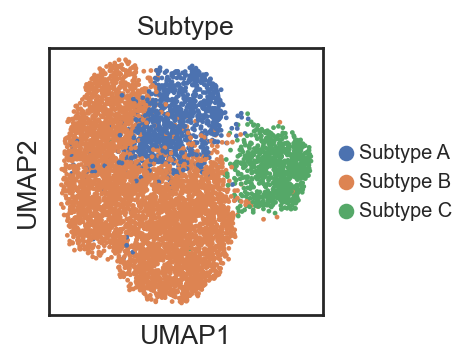

In [7]:
# Converting the cluster to category type
adata.obs['leiden_scVI'] = adata.obs['leiden_scVI'].astype('category')


adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='0']='2'
adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='1']='2'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['3'], 'Subtype B': ['2'], 'Subtype C': ['4']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i
    
    
# Plotting the subtype labeled umap
sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9)


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS152/OS152_scvI_subtype.h5ad")
